# The Sugarscape

## Motivation

**The Sugarscape**: Agent-based model with simple rules.
Can account for the transformation of a population through:
- natural selection 
- spatial segregation 
- migration
- emergence of wealth inequalities. 

The model is easily extended by introducing additional rules to add, e.g., trade, reproductive pressure, exchange of information, and environment pollution..


## Applications

- social science
- political science
- cooperation
- economics


## The Sugarscape.

The "Sugarscape" is a landscape (in the form of a lattice) where **sugar grows in each cell**.

The sugar provides energy and wealth.

**Agents explore the landscape** and, while doing it, harvest the sugar. 

- Each round, each agent move once. They move sequentially. Each round, the order in which the agent move is random.

- Two agents can't share the same cell: if an agent can't move on a free cell within its range, it remains in the cell it occupies.

- Each agent pays a metabilic cost to remain alive and move on the sugarscape. When their energy (that corresponds to their sugar level) falls below zero then they die of starvation.

At the end of each round, the **landscape regrowth the sugar** according to the growth rule $G_{\rm g}$.

For more details: see the book, page 16-5 and on.

### Features of the Sugarscape.

We start from the classical implementation: 

- squared lattice $N \times N$

- sugar full capacity of each cell: from 0 to 4

- landscape shaped like two sugar-hills

- rule $G_{\infty}$: at the end of each round, the sugar regrowth instantly to the maximum capacity of each cell.


### Agents on the Sugarscape.

Agents on sugarsape have the following features:

- vision: $v$ (uniform distribution $\in \{1, 2, ..., 6 \}$)
- sugar: $s$ (uniform distribution $\in \{5, 6, ... 25 \}$)
- metabolism: $m$ (uniform distribution $\in \{1, 2, 3, 4 \}$)

The vision determines the motion range.

The sugar is a reservoir of energy.


In [34]:
# Import dependencies
import pandas as pd
import numpy as np
from random import sample

In [35]:

def initialize_sugarscape(N):
    """
    Function to generate the "classical" sugarscape.
    
    Parameters
    ==========
    N : Side of the sugarscape lattice.
    """
    
    SuSca = np.zeros([N, N])
    X, Y = np.meshgrid(np.arange(N), np.arange(N))
    
    x_centers = np.array([N / 4, 3 * N / 4])
    y_centers = np.array([N / 4, 3 * N / 4])

    r_levels = np.array([4, 3, 2, 1]) / 4 * (np.sqrt(2) / 4) * N
    s_levels = np.array([1, 2, 3, 4])
    
    for k in range(np.size(x_centers)):
        d = np.sqrt((X - x_centers[k]) ** 2 +
                    (Y - y_centers[k]) ** 2)
        for i in range(np.size(s_levels)):
            region = np.where(d <= r_levels[i])
            SuSca[region[0], region[1]] = s_levels[i]
    
    return SuSca

# Function to convert a 2 dimensional numpy array into a RGB image.
def convert2RBG(game_outcome, RGB0, RGB1):
    """
    Function to convert the 2 dimensional numpy array into a RGB image.
    
    Parameters
    ==========
    game_outcome : Outcome of the prisoner's dilemma.
    RGB0 : Components R, G, B of the chosen color shade for minimum I_profile.
    RGB1 : Components R, G, B of the chosen color shade for maximum I_profile.
    """
    
    [n_rows, n_cols] = game_outcome.shape
    
    I_RGB = np.zeros([n_rows, n_cols, 3])
    
    # Set I_profile between 0 and 1
    game_outcome -= np.amin(game_outcome)    
    game_outcome /= np.amax(game_outcome)  
    
    for c in range(3):
        I_RGB[:, :, c] = game_outcome * RGB1[c] + (1 - game_outcome) * RGB0[c]

    return I_RGB

In [36]:
def move_agents(SuSca, Agents): # N_alive, V, S, M, x, y
    """
    Function to move the agents on the sugarscape.
    Implements one round where all the agents move once.
    
    Parameters
    ==========
    SuSca : Lattice representing the Sugarscape. 
    N_alive : Number of alive agents.
    V : Vision. 1-d numpy array.
    S : Sugar. 1-d numpy array.
    M : Metabolism. 1-d numpy array.
    x : x-position on the lattice of the agents. 1-d numpy array.
    y : y-position on the lattice of the agents. 1-d numpy array.
    """
    N_alive = Agents["Alive?"].sum() 

    SuSca_y, SuSca_x = SuSca.shape
    
    nSuSca = SuSca.copy()
    # print(nSuSca)
    # nx = x.copy()
    # ny = y.copy()
    # nS = S.copy()

    New_Agents = Agents.copy() 

    Alive_indices = np.where(Agents["Alive?"]==True)[0]
    Alive_x = New_Agents["X position"][Alive_indices]
    Alive_y = New_Agents["Y position"][Alive_indices]
    
    #print(len(Alive_indices))
    
    # Define the order of the agents in this round.   
    order = np.random.permutation(Alive_indices)            # permutation shuffle the indexes
    # print("Order: ", order)
    
    # For each agent: move it in the range of the vision.
    for i, na in enumerate(Alive_indices):
        ia = order[i]
        
        # Agent current position.
        # xa = nx[ia]
        # ya = ny[ia]
        # ma = M[ia]  # Metabolic rate.
        # va = V[ia]  # Vision.
        # sa = nS[ia]  # Available sugar/energy amount.
        xa = New_Agents["X position"][ia]
        ya = New_Agents["Y position"][ia]
        ma = New_Agents["Metabolic Rate"][ia]  # Metabolic rate.
        va = New_Agents["Vision"][ia]  # Vision.
        sa = New_Agents["Sugar Level"][ia]  # Available sugar/energy amount.
        
        # print(va)
        # print(xa)
        # Cells within the range of the agent.
        rx = np.zeros(va * 4 + 1) + xa
        ry = np.zeros(va * 4 + 1) + ya

        # First position is the current agents
        rx[0] = xa
        ry[0] = ya

        # Covers all cardinal directions
        rx[0 * va + 1:1 * va + 1] = xa + np.arange(va) + 1
        rx[1 * va + 1:2 * va + 1] = xa - np.arange(va) - 1
        ry[2 * va + 1:3 * va + 1] = ya + np.arange(va) + 1
        ry[3 * va + 1:4 * va + 1] = ya - np.arange(va) - 1

        # Wrapping around boundaries    
        rx = rx.astype(int) % SuSca_x
        ry = ry.astype(int) % SuSca_y

        # print("rx", rx)
        # print("ry", ry)
        sugar = nSuSca[ry, rx]        
        max_sugar = np.amax(sugar)
        searching_new_pos = True
        sugar_level = int(max_sugar)

        # print("\n")
        # print(f"Agent: {ia}, pos: {int(xa),int(ya)}")
        # print(list(map(int, (nSuSca[ry, rx]))))
        # print(rx)
        # print(ry)
        # print("Max sugar", sugar_level)
        
        # Agent looks for the best available position.
        while searching_new_pos:
            # Search options for a certain sugar level.
            options = np.where(sugar == sugar_level)[0]
            
            
            # For each option, check whether position is already occupied.            
            io = 0
            place_found = False

            while (io < np.size(options)) and (not place_found):
                i = options[io]
                x_ref = rx[i] % SuSca_x
                y_ref = ry[i] % SuSca_y

                # Check if the position is available.
                a_ref = np.intersect1d(
                    np.where(New_Agents.iloc[Alive_indices, 0] == x_ref)[0],
                    np.where(New_Agents.iloc[Alive_indices, 1] == y_ref)[0])
                
                if np.size(a_ref) == 0:
                    # Position is available
                    New_Agents.iloc[ia, 0] = x_ref 
                    New_Agents.iloc[ia, 1] = y_ref
                    New_Agents.iloc[ia, 4] += nSuSca[y_ref, x_ref]  # Agent takes the sugar.
                    nSuSca[y_ref, x_ref] = 0   # Sugarscape cell is depleted.
                    place_found = True
                else:
                    # Check whether this is the current position.
                    if (x_ref == New_Agents["X position"][ia]) and (y_ref == New_Agents["Y position"][ia]):
                        New_Agents.iloc[ia, 4] += nSuSca[y_ref, x_ref]  # Agent takes the sugar.
                        nSuSca[y_ref, x_ref] = 0   # Sugarscape cell is depleted.
                        place_found = True
                    else:
                        # The position is occupied by someone else.
                        io += 1
            
            # If we are here, we either have found a place or 
            # exausted the possibilities for this sugar_level
            
            if not place_found:
                if sugar_level > 0:
                    sugar_level -= 1
                else:
                    # The agent stays where it is.                    
                    New_Agents.iloc[ia, 4] += nSuSca[New_Agents["Y position"][ia], New_Agents["X position"][ia]]  # Agent takes the sugar.
                    nSuSca[New_Agents["Y position"][ia], New_Agents["X position"][ia]] = 0
                    searching_new_pos = False
            else: 
                # A place has been found for the agent.
                searching_new_pos = False
        # print(nSuSca[New_Agents["Y position"][ia], New_Agents["X position"][ia]] )
            
        # print("New pos: ", x_ref,y_ref)
            
        
    
    # All agents have moved.
    
    # Now pay the metabolic price.
    New_Agents.iloc[Alive_indices, 4] = New_Agents.iloc[Alive_indices, 4] - New_Agents.iloc[Alive_indices, 2]
    
    # Now check which agents are still alive.
    # still_alive = np.where(nS > 0)[0]
    
    # N_still_alive = np.size(still_alive)
    # V_alive = V[still_alive]
    # S_alive = nS[still_alive]
    # M_alive = M[still_alive]
    # x_alive = nx[still_alive]
    # y_alive = ny[still_alive]

    not_alive = np.where(New_Agents["Sugar Level"] <= 0)[0]
    New_Agents.iloc[not_alive, 5] = False
        
    return nSuSca, New_Agents #N_still_alive, V_alive, S_alive, M_alive, x_alive, y_alive




**Initialise and test agents**

In [37]:
N = 50 #50  # Size of the sugarscape with the agents.
A = 400 #400  # Number of agents on the sugarscape.

possible_m = np.arange(4) + 1  # Metabolic rate.
possible_v = np.arange(6) + 1  # Vision.
possible_s = np.arange(21) + 5  # Sugar.


# Define agents position. 
L = np.array(sample(range(N * N), A)).astype(int) 
x = L % N
y = ((L - x) / N).astype(int) 

data = {
    "X position": L % N,
    "Y position": ((L - x) / N).astype(int),
    "Metabolic Rate": np.random.randint(np.size(possible_m), size=A)+1,
    "Vision": np.random.randint(np.size(possible_v), size=A) + 1,
    "Sugar Level": np.random.randint(np.size(possible_s), size=A) + 5,
    "Alive?": np.full(A, True, dtype=bool)    
}
Agents = pd.DataFrame(data)
SuSca = initialize_sugarscape(N)

# Test to see move agents function 
#move_agents(SuSca, Agents)

print(Agents)
SuSca, test_Agents = move_agents(SuSca, Agents)
print(test_Agents)

     X position  Y position  Metabolic Rate  Vision  Sugar Level  Alive?
0            14           7               4       6           19    True
1             9          31               3       3           18    True
2            17          18               1       5           15    True
3            16          43               4       4           14    True
4             4          39               4       4           12    True
..          ...         ...             ...     ...          ...     ...
395          27          14               3       3           10    True
396          17          19               2       1            7    True
397          14          29               1       4           10    True
398          15           7               3       1           17    True
399          49          31               1       5           11    True

[400 rows x 6 columns]
     X position  Y position  Metabolic Rate  Vision  Sugar Level  Alive?
0            14          11

Initialize the sugarscape in the "classical" way.

Check whether the initialization works.

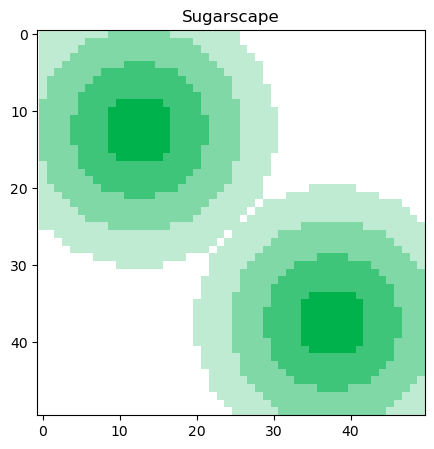

In [38]:
from matplotlib import pyplot as plt

N = 50  # Side of the sugarscape.

SuSca = initialize_sugarscape(N)

# Create the image of the game outcome.
RGB1 = [0.0, 0.7, 0.3]  # Orange. Color for high values.
RGB0 = [1.0, 1.0, 1.0]  # White. Color for low values.
SuSca_RGB = convert2RBG(SuSca, RGB0, RGB1)

# Plot the Sugarscape.
plt.figure(figsize=(5, 5))
plt.imshow(SuSca_RGB)  # Plot Sugarscape profile.
# Plot the reference points.
plt.title('Sugarscape')
plt.axis('equal')
plt.show()       


In [39]:
still_alive = np.where(Agents["Alive?"] == True)[0]

In [40]:
still_alive

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

## Simulation with animation --> Not working yet

In [41]:
''''import time 
from tkinter import Tk
from tkinter import Canvas

r0 = 0.25
N_skip = 1
MAX_STEP = 1001

N_alive_agents = np.zeros(MAX_STEP)

# Visualize status every N_skip steps. 
window_size = 600

#cell_color_list = ['#FFFFFF', '#C8E6C9', '#81C784', '#388E3C', '#1B5E20']
cell_color_list = ['#FFFFFF', '#FFECCE', '#FFCE88', '#FFA040', '#FF8000']

tk = Tk()
tk.geometry(f'{window_size + 20}x{window_size + 20}')
tk.configure(background='#000000')

canvas = Canvas(tk, background='#ECECEC')  # Generate animation window.
tk.attributes('-topmost', 0)
canvas.place(x=10, y=10, height=window_size, width=window_size)

step = 0

def stop_loop(event):
    global running
    running = False
tk.bind("<Escape>", stop_loop)  # Bind the Escape key to stop the loop.
running = True  # Flag to control the loop.
#print(int(SuSca[5, 1]))
while running:

    nSuSca, nAgents = move_agents(SuSca, Agents)
    still_alive = np.where(nAgents["Alive?"] == True)[0]
    #print(still_alive)

    # Update animation frame.
    if step % N_skip == 0:        
        canvas.delete('all')
        SU_cells = []
        for i in range(N):
            for j in range(N):
                cell_color = cell_color_list[int(nSuSca[i, j])]
                #
                SU_cells.append(
                    canvas.create_rectangle(
                        i / N * window_size, 
                        j / N * window_size,
                        (i + 1) / N * window_size,
                        (j + 1) / N * window_size, 
                        outline='', 
                        fill=cell_color,
                    )
                )
        Agents_circ = []
        for i in range(len(still_alive)):
            Agents_circ.append(
                canvas.create_oval(
                    (nAgents.loc[i, "X position"] + 0.5 - r0) / N * window_size, 
                    (nAgents.loc[i, "Y position"] + 0.5 - r0) / N * window_size,
                    (nAgents.loc[i, "X position"] + 0.5 + r0) / N * window_size,
                    (nAgents.loc[i, "Y position"] + 0.5 + r0) / N * window_size, 
                    outline='', 
                    fill='#000000',
                )
            )
        
        tk.title(f'Iteration {step}')
        tk.update_idletasks()
        tk.update()
        time.sleep(0.1)  # Increase to slow down the simulation.

    nAgents = Agents
    
    #A = nA
    #V = nV.copy()
    #S = nS.copy()
    #M = nM.copy()
    #x = nx.copy()
    #y = ny.copy()

    A = Agents[Agents["Alive?"]].copy()
    x = Agents["X position"].copy()
    y = Agents["Y position"].copy()
    M = Agents["Metabolic Rate"].copy() 
    V = Agents["Vision"].copy()
    S = Agents["Sugar Level"].copy()

    step += 1
    
tk.update_idletasks()
tk.update()
tk.mainloop()  # Release animation handle (close window to finish)
'''

'\'import time \nfrom tkinter import Tk\nfrom tkinter import Canvas\n\nr0 = 0.25\nN_skip = 1\nMAX_STEP = 1001\n\nN_alive_agents = np.zeros(MAX_STEP)\n\n# Visualize status every N_skip steps. \nwindow_size = 600\n\n#cell_color_list = [\'#FFFFFF\', \'#C8E6C9\', \'#81C784\', \'#388E3C\', \'#1B5E20\']\ncell_color_list = [\'#FFFFFF\', \'#FFECCE\', \'#FFCE88\', \'#FFA040\', \'#FF8000\']\n\ntk = Tk()\ntk.geometry(f\'{window_size + 20}x{window_size + 20}\')\ntk.configure(background=\'#000000\')\n\ncanvas = Canvas(tk, background=\'#ECECEC\')  # Generate animation window.\ntk.attributes(\'-topmost\', 0)\ncanvas.place(x=10, y=10, height=window_size, width=window_size)\n\nstep = 0\n\ndef stop_loop(event):\n    global running\n    running = False\ntk.bind("<Escape>", stop_loop)  # Bind the Escape key to stop the loop.\nrunning = True  # Flag to control the loop.\n#print(int(SuSca[5, 1]))\nwhile running:\n\n    nSuSca, nAgents = move_agents(SuSca, Agents)\n    still_alive = np.where(nAgents["Alive?"

## Without animation

Now let's try without animation.

In [42]:
from random import sample

N = 50 #50  # Size of the sugarscape with the agents.
A = 400 #400  # Number of agents on the sugarscape.

possible_m = np.arange(4) + 1  # Metabolic rate.
possible_v = np.arange(6) + 1  # Vision.
possible_s = np.arange(21) + 5  # Sugar.

# Define agents position. 
L = np.array(sample(range(N * N), A)).astype(int) 
x = L % N
y = ((L - x) / N).astype(int) 
# This way each agent occupy a different cell.

# New Initialize agents
data = {
    "X position": L % N,
    "Y position": ((L - x) / N).astype(int),
    "Metabolic Rate": np.random.randint(np.size(possible_m), size=A)+1,
    "Vision": np.random.randint(np.size(possible_v), size=A) + 1,
    "Sugar Level": np.random.randint(np.size(possible_s), size=A) + 5,
    "Alive?": np.full(A, True, dtype=bool)    
}

# data = {
#     "X position": L % N,
#     "Y position": ((L - x) / N).astype(int),
#     "Metabolic Rate": 1,
#     "Vision": 4,
#     "Sugar Level": 5,
#     "Alive?": np.full(A, True, dtype=bool)    
# }

Agents = pd.DataFrame(data)

# Initial values
Agents0 = Agents.copy()

SuSca = initialize_sugarscape(N)


[[0.25 0.25 0.25 ... 0.   0.   0.  ]
 [0.25 0.25 0.25 ... 0.   0.   0.  ]
 [0.25 0.25 0.25 ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 0.25 0.25 0.25]
 [0.   0.   0.   ... 0.25 0.25 0.25]
 [0.   0.   0.   ... 0.25 0.25 0.25]]


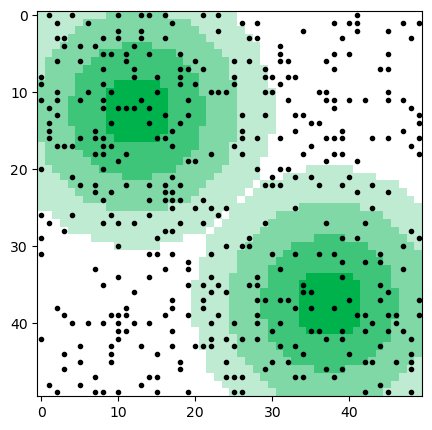

     X position  Y position  Metabolic Rate  Vision  Sugar Level  Alive?
0            12           4               2       4           11    True
1            49          29               4       4            5    True
2             2          11               1       3            5    True
3            44          37               4       5           20    True
4            33           8               2       3           25    True
..          ...         ...             ...     ...          ...     ...
395          17          43               2       4           10    True
396          25          47               1       3           20    True
397           1          27               4       5           12    True
398           3           3               4       5           22    True
399          37           6               3       2           23    True

[400 rows x 6 columns]


In [43]:
SuSca_RGB = convert2RBG(SuSca, RGB0, RGB1)
print(SuSca)

plt.figure(figsize=(5, 5))
plt.imshow(SuSca_RGB)
plt.plot(Agents["X position"], Agents["Y position"], '.', color='k')
plt.show()

print(Agents)

## Simultion without animation

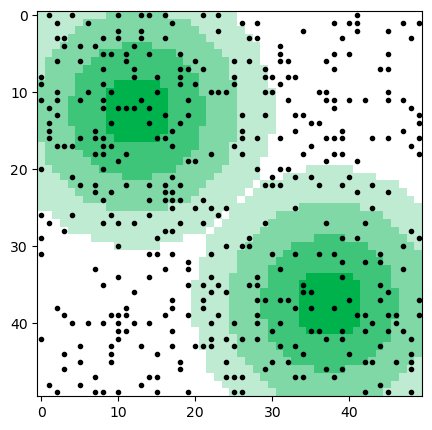

/var/folders/g7/7d8l4vfx5cg1cd6cz4d3ml_w0000gn/T/ipykernel_47054/1402901443.py:133: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '24.75' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  New_Agents.iloc[ia, 4] += nSuSca[New_Agents["Y position"][ia], New_Agents["X position"][ia]]  # Agent takes the sugar.


     X position  Y position  Metabolic Rate  Vision  Sugar Level  Alive?
0            12           4               2       4           11    True
1            49          29               4       4            5    True
2             2          11               1       3            5    True
3            44          37               4       5           20    True
4            33           8               2       3           25    True
..          ...         ...             ...     ...          ...     ...
395          17          43               2       4           10    True
396          25          47               1       3           20    True
397           1          27               4       5           12    True
398           3           3               4       5           22    True
399          37           6               3       2           23    True

[400 rows x 6 columns]


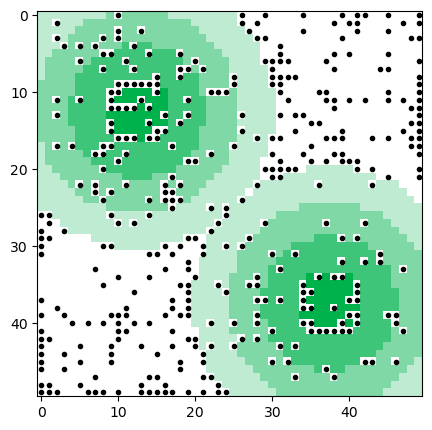

     X position  Y position  Metabolic Rate  Vision  Sugar Level  Alive?
0            12           4               2       4         4.75    True
1             1          29               4       4        -3.00   False
2             2          11               1       3         2.50    True
3            41          37               4       5         5.00    True
4            33           8               2       3        15.00    True
..          ...         ...             ...     ...          ...     ...
395          17          43               2       4         0.00   False
396          22          47               1       3        15.00    True
397           1          27               4       5         0.00   False
398          49           3               4       5         2.00    True
399          37           6               3       2         8.00    True

[400 rows x 6 columns]


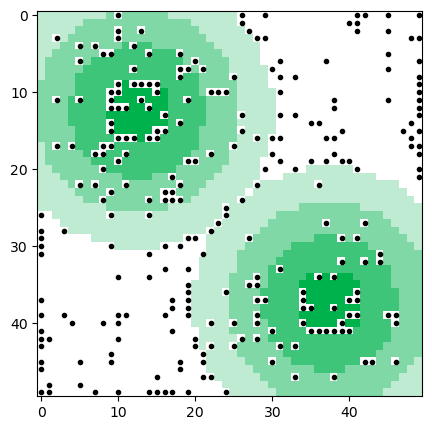

     X position  Y position  Metabolic Rate  Vision  Sugar Level  Alive?
0            12           4               2       4        -0.25   False
1             1          29               4       4        -3.00   False
2            49          11               1       3        -0.50   False
3            41          37               4       5        -1.00   False
4            33           8               2       3         5.00    True
..          ...         ...             ...     ...          ...     ...
395          17          43               2       4         0.00   False
396          22          47               1       3        10.00    True
397           1          27               4       5         0.00   False
398          49           3               4       5        -2.00   False
399          37           6               3       2        -1.00   False

[400 rows x 6 columns]


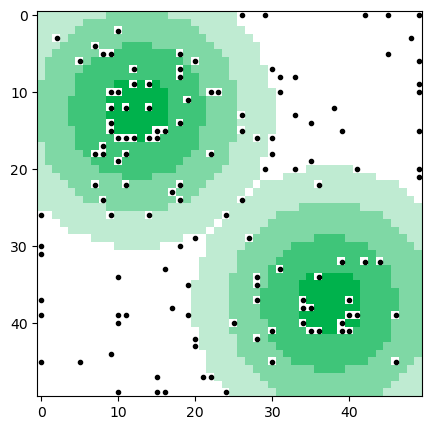

     X position  Y position  Metabolic Rate  Vision  Sugar Level  Alive?
0            12           4               2       4        -0.25   False
1             1          29               4       4        -3.00   False
2            49          11               1       3        -0.50   False
3            41          37               4       5        -1.00   False
4            33           8               2       3        -1.00   False
..          ...         ...             ...     ...          ...     ...
395          17          43               2       4         0.00   False
396          22          47               1       3         5.00    True
397           1          27               4       5         0.00   False
398          49           3               4       5        -2.00   False
399          37           6               3       2        -1.00   False

[400 rows x 6 columns]


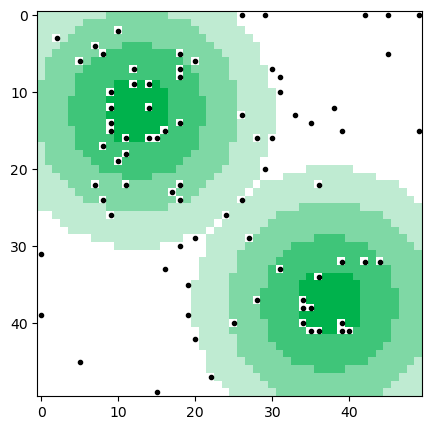

     X position  Y position  Metabolic Rate  Vision  Sugar Level  Alive?
0            12           4               2       4        -0.25   False
1             1          29               4       4        -3.00   False
2            49          11               1       3        -0.50   False
3            41          37               4       5        -1.00   False
4            33           8               2       3        -1.00   False
..          ...         ...             ...     ...          ...     ...
395          17          43               2       4         0.00   False
396          22          47               1       3         0.00   False
397           1          27               4       5         0.00   False
398          49           3               4       5        -2.00   False
399          37           6               3       2        -1.00   False

[400 rows x 6 columns]


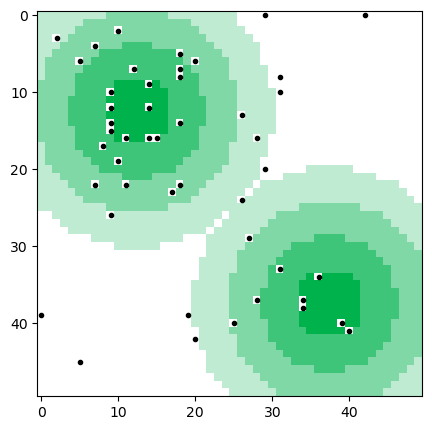

     X position  Y position  Metabolic Rate  Vision  Sugar Level  Alive?
0            12           4               2       4        -0.25   False
1             1          29               4       4        -3.00   False
2            49          11               1       3        -0.50   False
3            41          37               4       5        -1.00   False
4            33           8               2       3        -1.00   False
..          ...         ...             ...     ...          ...     ...
395          17          43               2       4         0.00   False
396          22          47               1       3         0.00   False
397           1          27               4       5         0.00   False
398          49           3               4       5        -2.00   False
399          37           6               3       2        -1.00   False

[400 rows x 6 columns]


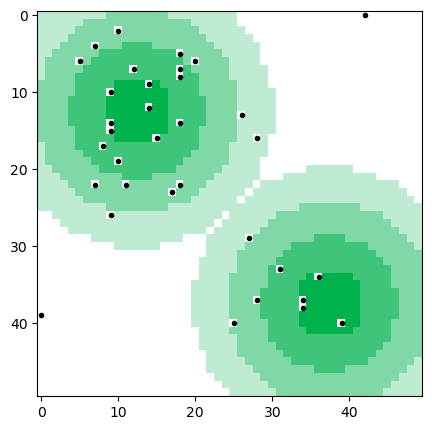

     X position  Y position  Metabolic Rate  Vision  Sugar Level  Alive?
0            12           4               2       4        -0.25   False
1             1          29               4       4        -3.00   False
2            49          11               1       3        -0.50   False
3            41          37               4       5        -1.00   False
4            33           8               2       3        -1.00   False
..          ...         ...             ...     ...          ...     ...
395          17          43               2       4         0.00   False
396          22          47               1       3         0.00   False
397           1          27               4       5         0.00   False
398          49           3               4       5        -2.00   False
399          37           6               3       2        -1.00   False

[400 rows x 6 columns]


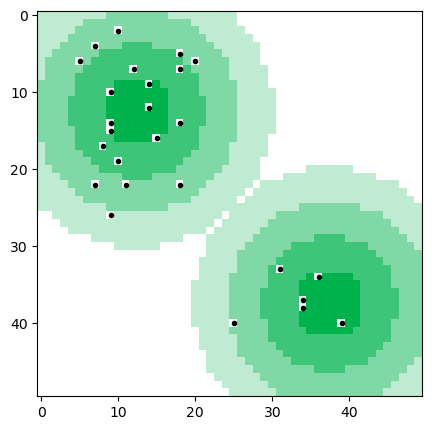

     X position  Y position  Metabolic Rate  Vision  Sugar Level  Alive?
0            12           4               2       4        -0.25   False
1             1          29               4       4        -3.00   False
2            49          11               1       3        -0.50   False
3            41          37               4       5        -1.00   False
4            33           8               2       3        -1.00   False
..          ...         ...             ...     ...          ...     ...
395          17          43               2       4         0.00   False
396          22          47               1       3         0.00   False
397           1          27               4       5         0.00   False
398          49           3               4       5        -2.00   False
399          37           6               3       2        -1.00   False

[400 rows x 6 columns]


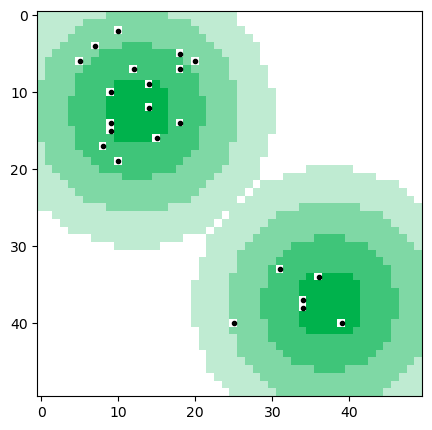

     X position  Y position  Metabolic Rate  Vision  Sugar Level  Alive?
0            12           4               2       4        -0.25   False
1             1          29               4       4        -3.00   False
2            49          11               1       3        -0.50   False
3            41          37               4       5        -1.00   False
4            33           8               2       3        -1.00   False
..          ...         ...             ...     ...          ...     ...
395          17          43               2       4         0.00   False
396          22          47               1       3         0.00   False
397           1          27               4       5         0.00   False
398          49           3               4       5        -2.00   False
399          37           6               3       2        -1.00   False

[400 rows x 6 columns]


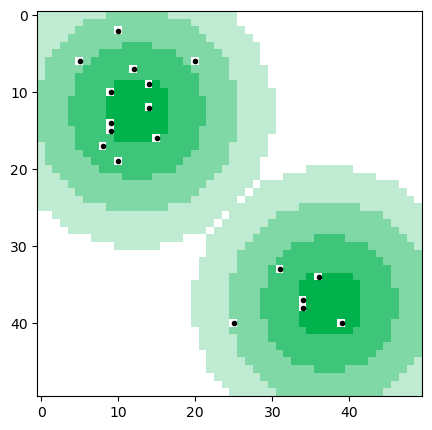

     X position  Y position  Metabolic Rate  Vision  Sugar Level  Alive?
0            12           4               2       4        -0.25   False
1             1          29               4       4        -3.00   False
2            49          11               1       3        -0.50   False
3            41          37               4       5        -1.00   False
4            33           8               2       3        -1.00   False
..          ...         ...             ...     ...          ...     ...
395          17          43               2       4         0.00   False
396          22          47               1       3         0.00   False
397           1          27               4       5         0.00   False
398          49           3               4       5        -2.00   False
399          37           6               3       2        -1.00   False

[400 rows x 6 columns]


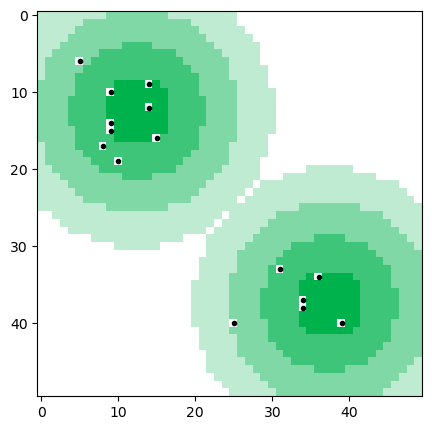

     X position  Y position  Metabolic Rate  Vision  Sugar Level  Alive?
0            12           4               2       4        -0.25   False
1             1          29               4       4        -3.00   False
2            49          11               1       3        -0.50   False
3            41          37               4       5        -1.00   False
4            33           8               2       3        -1.00   False
..          ...         ...             ...     ...          ...     ...
395          17          43               2       4         0.00   False
396          22          47               1       3         0.00   False
397           1          27               4       5         0.00   False
398          49           3               4       5        -2.00   False
399          37           6               3       2        -1.00   False

[400 rows x 6 columns]


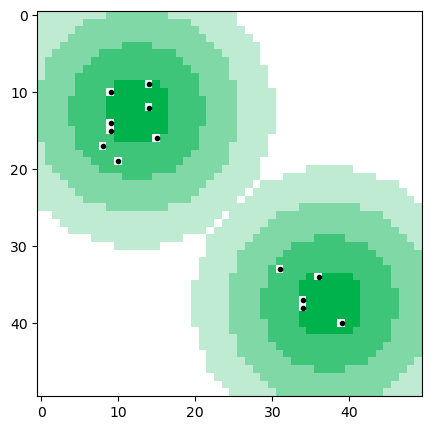

     X position  Y position  Metabolic Rate  Vision  Sugar Level  Alive?
0            12           4               2       4        -0.25   False
1             1          29               4       4        -3.00   False
2            49          11               1       3        -0.50   False
3            41          37               4       5        -1.00   False
4            33           8               2       3        -1.00   False
..          ...         ...             ...     ...          ...     ...
395          17          43               2       4         0.00   False
396          22          47               1       3         0.00   False
397           1          27               4       5         0.00   False
398          49           3               4       5        -2.00   False
399          37           6               3       2        -1.00   False

[400 rows x 6 columns]


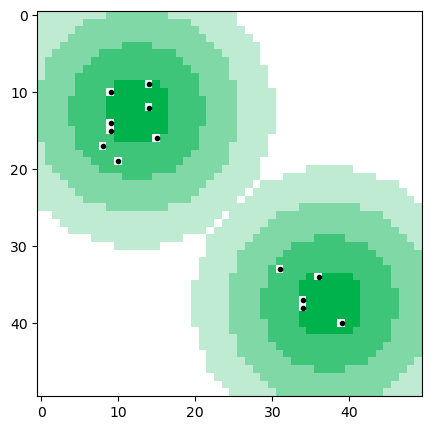

     X position  Y position  Metabolic Rate  Vision  Sugar Level  Alive?
0            12           4               2       4        -0.25   False
1             1          29               4       4        -3.00   False
2            49          11               1       3        -0.50   False
3            41          37               4       5        -1.00   False
4            33           8               2       3        -1.00   False
..          ...         ...             ...     ...          ...     ...
395          17          43               2       4         0.00   False
396          22          47               1       3         0.00   False
397           1          27               4       5         0.00   False
398          49           3               4       5        -2.00   False
399          37           6               3       2        -1.00   False

[400 rows x 6 columns]


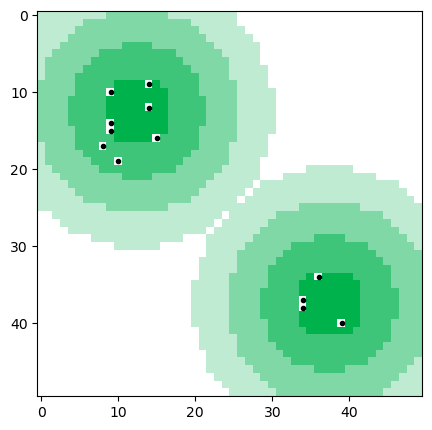

     X position  Y position  Metabolic Rate  Vision  Sugar Level  Alive?
0            12           4               2       4        -0.25   False
1             1          29               4       4        -3.00   False
2            49          11               1       3        -0.50   False
3            41          37               4       5        -1.00   False
4            33           8               2       3        -1.00   False
..          ...         ...             ...     ...          ...     ...
395          17          43               2       4         0.00   False
396          22          47               1       3         0.00   False
397           1          27               4       5         0.00   False
398          49           3               4       5        -2.00   False
399          37           6               3       2        -1.00   False

[400 rows x 6 columns]


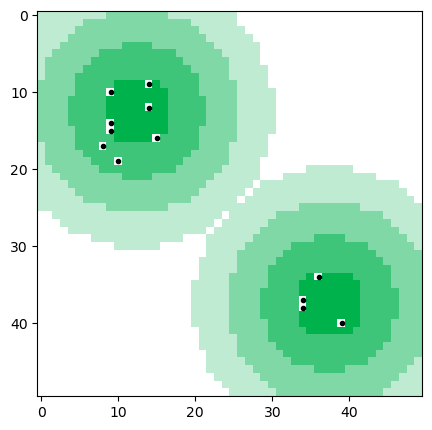

     X position  Y position  Metabolic Rate  Vision  Sugar Level  Alive?
0            12           4               2       4        -0.25   False
1             1          29               4       4        -3.00   False
2            49          11               1       3        -0.50   False
3            41          37               4       5        -1.00   False
4            33           8               2       3        -1.00   False
..          ...         ...             ...     ...          ...     ...
395          17          43               2       4         0.00   False
396          22          47               1       3         0.00   False
397           1          27               4       5         0.00   False
398          49           3               4       5        -2.00   False
399          37           6               3       2        -1.00   False

[400 rows x 6 columns]


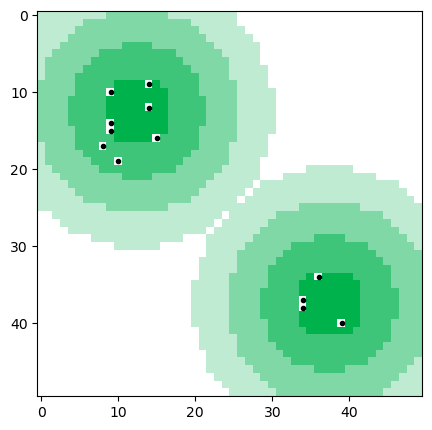

     X position  Y position  Metabolic Rate  Vision  Sugar Level  Alive?
0            12           4               2       4        -0.25   False
1             1          29               4       4        -3.00   False
2            49          11               1       3        -0.50   False
3            41          37               4       5        -1.00   False
4            33           8               2       3        -1.00   False
..          ...         ...             ...     ...          ...     ...
395          17          43               2       4         0.00   False
396          22          47               1       3         0.00   False
397           1          27               4       5         0.00   False
398          49           3               4       5        -2.00   False
399          37           6               3       2        -1.00   False

[400 rows x 6 columns]


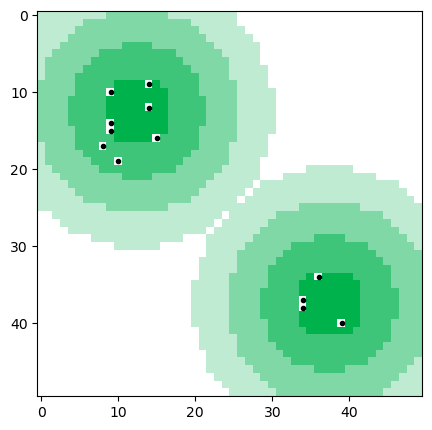

     X position  Y position  Metabolic Rate  Vision  Sugar Level  Alive?
0            12           4               2       4        -0.25   False
1             1          29               4       4        -3.00   False
2            49          11               1       3        -0.50   False
3            41          37               4       5        -1.00   False
4            33           8               2       3        -1.00   False
..          ...         ...             ...     ...          ...     ...
395          17          43               2       4         0.00   False
396          22          47               1       3         0.00   False
397           1          27               4       5         0.00   False
398          49           3               4       5        -2.00   False
399          37           6               3       2        -1.00   False

[400 rows x 6 columns]


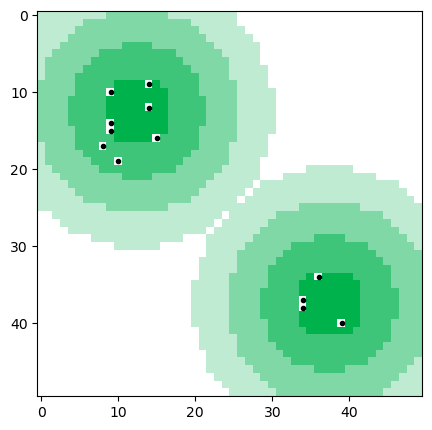

     X position  Y position  Metabolic Rate  Vision  Sugar Level  Alive?
0            12           4               2       4        -0.25   False
1             1          29               4       4        -3.00   False
2            49          11               1       3        -0.50   False
3            41          37               4       5        -1.00   False
4            33           8               2       3        -1.00   False
..          ...         ...             ...     ...          ...     ...
395          17          43               2       4         0.00   False
396          22          47               1       3         0.00   False
397           1          27               4       5         0.00   False
398          49           3               4       5        -2.00   False
399          37           6               3       2        -1.00   False

[400 rows x 6 columns]


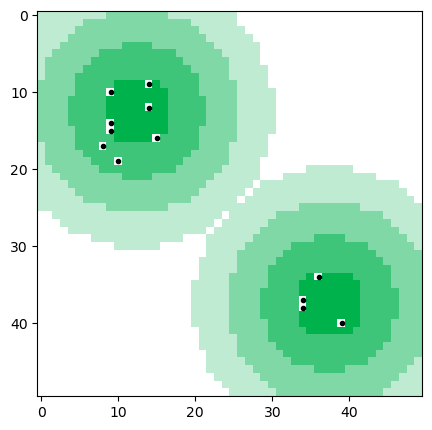

     X position  Y position  Metabolic Rate  Vision  Sugar Level  Alive?
0            12           4               2       4        -0.25   False
1             1          29               4       4        -3.00   False
2            49          11               1       3        -0.50   False
3            41          37               4       5        -1.00   False
4            33           8               2       3        -1.00   False
..          ...         ...             ...     ...          ...     ...
395          17          43               2       4         0.00   False
396          22          47               1       3         0.00   False
397           1          27               4       5         0.00   False
398          49           3               4       5        -2.00   False
399          37           6               3       2        -1.00   False

[400 rows x 6 columns]


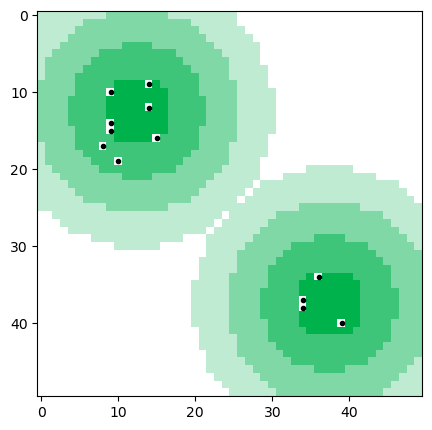

     X position  Y position  Metabolic Rate  Vision  Sugar Level  Alive?
0            12           4               2       4        -0.25   False
1             1          29               4       4        -3.00   False
2            49          11               1       3        -0.50   False
3            41          37               4       5        -1.00   False
4            33           8               2       3        -1.00   False
..          ...         ...             ...     ...          ...     ...
395          17          43               2       4         0.00   False
396          22          47               1       3         0.00   False
397           1          27               4       5         0.00   False
398          49           3               4       5        -2.00   False
399          37           6               3       2        -1.00   False

[400 rows x 6 columns]


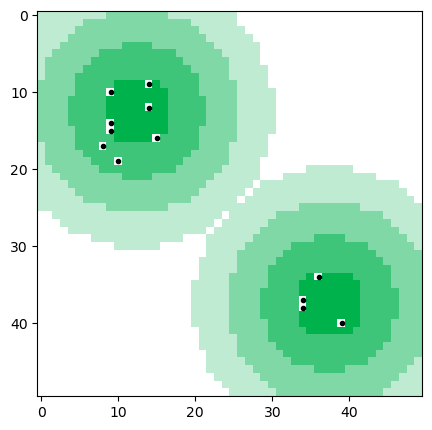

In [ ]:
SuSca_RGB = convert2RBG(SuSca, RGB0, RGB1)
# print(SuSca)

plt.figure(figsize=(5, 5))
plt.imshow(SuSca_RGB)
plt.plot(Agents["X position"], Agents["Y position"], '.', color='k')
plt.show()

from IPython.display import clear_output
from matplotlib import pyplot as plt
    
# Create the image of the game outcome.
#RGB1 = [1.0, 0.5, 0.0]  # Orange. Color for high values.
RGB1 = [0.0, 0.7, 0.3]
RGB0 = [1.0, 1.0, 1.0]  # White. Color for low values.

MAX_STEP = 100#1001
N_skip = 5 #200
step = 0

N_alive_agents = np.zeros(MAX_STEP)

running = True  # Flag to control the loop.
while running:
    
    N_alive_agents[step] = Agents["Alive?"].sum()
    Alive_agents = np.where(Agents["Alive?"]==True)[0]

    nSuSca, New_Agents= move_agents(SuSca, Agents) # A, V, S, M, x, y   nA, nV, nS, nM, nx, ny
    # print(nSuSca)
    if step % N_skip == 0:  
        print(Agents) 
        SuSca_RGB = convert2RBG(nSuSca, RGB0, RGB1)

        plt.figure(figsize=(5, 5))
        plt.imshow(SuSca_RGB)
        plt.plot(New_Agents["X position"][Alive_agents], New_Agents["Y position"][Alive_agents], '.', color='k')
        plt.show()

    
    # A = nA
    # V = nV.copy()
    # S = nS.copy()
    # M = nM.copy()
    # x = nx.copy()
    # y = ny.copy()

    # SuSca = nSuSca.copy()

    Agents = New_Agents.copy()
    step += 1
    
    if step >= MAX_STEP:
        running = False

        
# Final Values
# M1 = M.copy()
# S1 = S.copy()
# V1 = V.copy()

Agents1 = Agents.copy()

print(Agents1['Alive?'])



In [53]:
print(f'Agents alive after {MAX_STEP} steps: \n \n {Agents1[Agents1['Alive?'] == True]} ')

Agents alive after 100 steps: 
 
      X position  Y position  Metabolic Rate  Vision  Sugar Level  Alive?
36           15          16               1       1         17.0    True
37           34          37               1       6         17.0    True
59           36          34               1       4         23.0    True
85            9          15               1       5         25.0    True
94            9          14               1       6         24.0    True
160          34          38               1       1         23.0    True
163           9          10               1       5         19.0    True
198          14          12               1       4          8.0    True
280          14           9               1       6         14.0    True
374          39          40               1       5         21.0    True 


## ------------------ lecture code below ------------------

Compare histograms:

In [45]:
print(A)

400


#### Metabolism

In [46]:
# Metabolism: initial and final distribution.
m_bins = possible_m
m_bins_edges = np.arange(np.amin(possible_m) - 0.5, np.amax(possible_m) + 0.6)
m_ini_h, m_ini_e = np.histogram(M0, bins=m_bins_edges)
m_fin_h, m_fin_e = np.histogram(M1, bins=m_bins_edges)


plt.figure(figsize=(10, 5))
plt.bar(m_bins, m_ini_h, width=0.8, edgecolor='k', label='initial')
plt.bar(m_bins, m_fin_h, width=0.4, edgecolor='k', label='final')
plt.legend()
plt.xlabel('m')
plt.title('metabolism')
plt.show()





NameError: name 'M0' is not defined

#### Vision

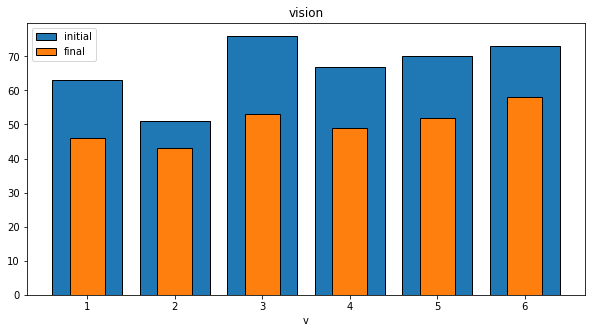

In [ ]:
# Vision: initial and final distribution.
v_bins = possible_v
v_bins_edges = np.arange(np.amin(possible_v) - 0.5, np.amax(possible_v) + 0.6)
v_ini_h, v_ini_e = np.histogram(V0, bins=v_bins_edges)
v_fin_h, v_fin_e = np.histogram(V1, bins=v_bins_edges)


plt.figure(figsize=(10, 5))
plt.bar(v_bins, v_ini_h, width=0.8, edgecolor='k', label='initial')
plt.bar(v_bins, v_fin_h, width=0.4, edgecolor='k', label='final')
plt.legend()
plt.xlabel('v')
plt.title('vision')
plt.show()


#### Sugar

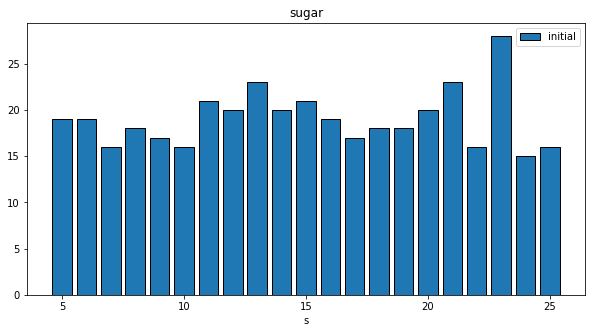

In [ ]:
# Sugar: initial and final distribution.
s_bins_i = possible_s
s_bins_edges_i = np.arange(np.amin(possible_s) - 0.5, np.amax(possible_s) + 0.6)
s_ini_h, s_ini_e = np.histogram(S0, bins=s_bins_edges_i)

plt.figure(figsize=(10, 5))
plt.bar(s_bins_i, s_ini_h, width=0.8, edgecolor='k', label='initial')
plt.legend()
plt.xlabel('s')
plt.title('sugar')
plt.show()




### Lorenz curve and Gini coefficient.

Measure of equality in wealth / resources distribution 

In [ ]:
def Lorenz_curve(s):
    """
    Function to generate the Lorenz curve from a sequence of data.
    
    Parameters
    ==========
    s : Sugar of each agent.
    """
    
    N = np.size(s)
    
    population_fraction = np.arange(N) / N
    
    s_sorted = np.sort(s)
    
    cumulative_s_fraction = np.cumsum(s_sorted) / np.sum(s_sorted)
    
    
    return cumulative_s_fraction, population_fraction

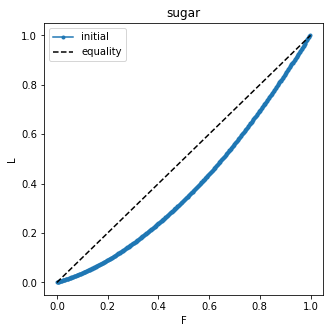

In [ ]:
L0, F0 = Lorenz_curve(S0)


plt.figure(figsize=(5, 5))
plt.plot(F0, L0, '.-', label='initial')
plt.plot([0, 1], [0, 1], '--', color='k', label='equality')
plt.legend()
plt.xlabel('F')
plt.ylabel('L')
plt.title('sugar')
plt.show()


